# Outcomes

This notebook contains the steps used to analyze the outcomes of this ADS, in three parts. 


In [8]:
# Preliminary imports


import os
import gc
import re
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


feature_importances = pd.read_csv('feature_importance_model2_04.csv')

decisions = pd.read_csv('oof_model2_04.csv')

submission = pd.read_csv('submission_model2_04.csv')

test = pd.read_csv('../../../home-credit-default-risk/application_test.csv')
train = pd.read_csv('../../../home-credit-default-risk/application_train.csv')

data = train.merge(decisions[['SK_ID_CURR','PREDICTIONS']],on='SK_ID_CURR',how='left')
test = test.merge(submission[['SK_ID_CURR','TARGET']],on='SK_ID_CURR',how='left')

data.dropna(subset=['PREDICTIONS'],axis=0,inplace=True)

# Part I:  Analyze the effectiveness (accuracy) of the ADS by comparing its performance across different subpopulations.

There are several sub-populations of interest we can explore. 

We begin by observing the overall AUC, serving as our starting point.


In [9]:
# Compute AUC

full_auc = roc_auc_score(data['TARGET'],data['PREDICTIONS'])

print("The overall ADS AUC score on the training + validation set is ", full_auc)

The overall ADS AUC score on the training + validation set is  0.7996349323611904


This is the overall AUC score achieved. Now we want to compare how different sub-populations do on this. 


In [10]:
def subpopulation_AUC(data,col='CODE_GENDER',protected = 'F',continuous=False):
    """
    Compare model performance across subpopulations compared to the overall performance. 
    
    Since AUC is the target metric of this ADS, we will use this value to start for comparison. 
    
    
    """
    
    if continuous:
        unpriviledged_group = data.loc[data[col] >= protected]
    else:
        unpriviledged_group = data.loc[data[col] == protected] 

    unpriveledged_auc = roc_auc_score(unpriviledged_group['TARGET'],unpriviledged_group['PREDICTIONS'])
    overall_auc = roc_auc_score(data['TARGET'],data['PREDICTIONS'])

    
    return unpriveledged_auc,  unpriveledged_auc - overall_auc


In [11]:
gender_auc, diff = subpopulation_AUC(data,col='CODE_GENDER',protected = 'F')
print("For the female only sub-population, the recovered AUC is ", gender_auc, ". This differs from the starting AUC by ", diff)

For the female only sub-population, the recovered AUC is  0.7994648552224612 . This differs from the starting AUC by  -0.0001700771387291855


For gender, we observe that the ADS performs a little bit worse on the Female only sub-population. 

In [12]:
car_auc , diff = subpopulation_AUC(data,col='FLAG_OWN_CAR',protected = 'N')


print("For the non-car-owning sub-population, the recovered AUC is ", car_auc, ". This differs from the starting AUC by ", diff)





For the non-car-owning sub-population, the recovered AUC is  0.7997225072422942 . This differs from the starting AUC by  8.75748811037802e-05


For owning a car, we observe that this model ADS performs about the same regardless of this attribute. It is worth noting that this says nothing about the potential disparity between folks who own cars and those who don't, but this attribute does not impact evaluation performance. 

In [13]:
family_auc, diff = subpopulation_AUC(data,col='NAME_FAMILY_STATUS',protected = 'Widow')



print("For the widow sub-population, the recovered AUC is ", family_auc, ". This differs from the starting AUC by ", diff)



For the widow sub-population, the recovered AUC is  0.7720119068893594 . This differs from the starting AUC by  -0.027623025471831042


For the sub-population of widows, this model performs notably worse compared to the overall AUC. This could be an attribute worth exploring more. 

In [14]:
edu_auc, diff = subpopulation_AUC(data,col='NAME_EDUCATION_TYPE',protected = 'Lower secondary')


print("For the sub-population with only a lower secondary educational degree, the recovered AUC is ", edu_auc, ". This differs from the starting AUC by ", diff)



For the sub-population with only a lower secondary educational degree, the recovered AUC is  0.7740582467829796 . This differs from the starting AUC by  -0.0255766855782108


For education, folks with a lower secondary degree also appear to be impacted negatively. 

In [15]:
child_auc, diff = subpopulation_AUC(data,col='CNT_CHILDREN',protected = 1,continuous=True)


print("For the sub-population with 1 or more children, the recovered AUC is ", child_auc, ". This differs from the starting AUC by ", diff)




For the sub-population with 1 or more children, the recovered AUC is  0.800912526040215 . This differs from the starting AUC by  0.00127759367902458


Not entirely sure how to approach this for continuous values, but clearly there is some sort of disparity based on the number of children the applicant has, but it is certainly ambigiuous on what threshold to use. For now using 1, and we find that there is a slight difference between this group and overall. 

# Part II: Select one or several fairness or diversity measures, justify your choice of these measures for the ADS in question, and quantify the fairness or diversity of this ADS.

Now using the test set, we are exploring how if this ADS is deployed in the wild, to an extent, whether or not our fairness metrics help us identify any signficant disparities between sub-populations which are worth future auditing. 

In [16]:
test.rename(columns={"TARGET":"PREDICTIONS"},inplace=True)
def disparate_impact_calculator(data,col='CODE_GENDER',protected = 'F',continuous=False):
    
    if continuous:
        
        unpriviledged_group = data.loc[data[col] >= protected]
        priviledged_group = data.loc[data[col] < protected] 
        # a little ambiguous, but for some continuous values we could consider the protected class above, 
        # and the other below.
        # If not, just invert the recovered value!
        
    else: 
        
        unpriviledged_group = data.loc[data[col] == protected]
        priviledged_group = data.loc[data[col] != protected]

    return unpriviledged_group['PREDICTIONS'].mean()/priviledged_group['PREDICTIONS'].mean()

In [17]:
x = disparate_impact_calculator(test,col='CODE_GENDER',protected = 'F')
y = disparate_impact_calculator(data,col='CODE_GENDER',protected = 'F')


print("The disparate impact based on gender is ", y, ' in the training set, and ',x,' in the test set.')

The disparate impact based on gender is  0.7083307651872992  in the training set, and  0.6652394750744546  in the test set.


The ideal value for this attribute is 1. Not only do we observe a pretty significant deviation from this value, but we see that it gets worse when we move to test! 

In [18]:
x = disparate_impact_calculator(test,col='FLAG_OWN_CAR',protected = 'N')

y = disparate_impact_calculator(data,col='FLAG_OWN_CAR',protected = 'N')


print("The disparate impact based on car ownership is ", y, ' in the training set, and ',x,' in the test set.')

The disparate impact based on car ownership is  1.1521600724246586  in the training set, and  1.1030948497130701  in the test set.


Perhaps surpisingly, those who do not own cars are actually better off than those who do. There are a few explanations for this, but one hypothesis is that having a car means added expenses, thus making it less feasible for the applicant to pay a loan. 

In [19]:
x = disparate_impact_calculator(test,col='NAME_FAMILY_STATUS',protected = 'Widow')

y = disparate_impact_calculator(data,col='NAME_FAMILY_STATUS',protected = 'Widow')


print("The disparate impact based on being a widow is ", y, ' in the training set, and ',x,' in the test set.')

The disparate impact based on being a widow is  0.7041094851584311  in the training set, and  0.6719221685992843  in the test set.


Similar to gender, widow sub-population faces disparate impact. 

In [20]:
x = disparate_impact_calculator(test,col='NAME_EDUCATION_TYPE',protected = 'Lower secondary')
y = disparate_impact_calculator(data,col='NAME_EDUCATION_TYPE',protected = 'Lower secondary')


print("The disparate impact based on having a Lower secondary education status is ", y, ' in the training set, and ',x,' in the test set.')

The disparate impact based on having a Lower secondary education status is  1.3089180914564904  in the training set, and  1.2640341635584056  in the test set.


Perhaps surprisingly, it is easier for lower secondary to receive favorable ratings than other edcuational status groups. 

In [21]:
x = disparate_impact_calculator(test,col='CNT_CHILDREN',protected = 1,continuous=True)
y = disparate_impact_calculator(data,col='CNT_CHILDREN',protected = 1,continuous=True)

print("The disparate impact based on having one or more children is ", y, ' in the training set, and ',x,' in the test set.')

The disparate impact based on having one or more children is  1.1481827472311983  in the training set, and  1.1228517036866072  in the test set.


A little bit of favor to those who have children, explanation could be that since these are typically older applicants, children are probably working, and as such, would be able to help support loan repayment if necessary. 

# Part III: Develop additional methods for analyzing ADS performance: think about stability, robustness, performance on difficult or otherwise important examples (in the style of LIME), or any other property that you believe is important to check for this ADS.

There are two things to consider for this ADS. First we want to take what were the sub-populations which demonstrated the most disparity from the measures above, and based on the system's feature importances, see if we can intuit as to why this might be the case, and based on that hypothesize on potential mitigation strategies from there. 


The next thing to understand are some local predictions, in particular for the most and least confident decisions made by the ADS.

The most confident scores will be prediction values near 0 or 1, and least confident will be predictions right around .5

Unfortunately LIME is not a feasible tool since this ADS works with NaN and infinite values, something not yet manageable for implentations of LIME or SHAP. Instead, another important aspect for transparency we choose to examine are provided feature importances, and allow that to guide our understanding of this ADS in this next step. 

In [22]:
feature_importances.head()

,feature,gain,split
0,EXT_SOURCES_MEAN,630312.097774,1627.9
1,EXT_SOURCES_NANMEDIAN,288492.997356,1361.8
2,EXT_SOURCES_MIN,232531.100522,1376.2
3,ORGANIZATION_TYPE,184313.908802,7139.4
4,EXT_SOURCES_MAX,131637.630816,1076.7


Firstly, it appears that the most prominent features are associated with external sources of income. This is certainly a favorable result, since even with a basic understanding of how credit approval works, we would expect that one's determination for a loan is based on their current sources of income, and whether or not that could be sufficent enough a source for repayment. We can see from above that this is the case. However, we are already aware of potential issues associated with features like gender, so the next step is to see where in this feature importance list Gender resides. 

In [27]:
feature_importances.loc[feature_importances['feature'].str.contains("GENDER")].index / feature_importances.shape[0]

Float64Index([0.0380517503805175], dtype='float64')

As we can see above, the gender attribute is in the top 4% of feature importances. 


Next, we can try a simple aggregation technique which sheds some light on the particular domain these top features come from, and see if it provides any additional insight.


In [28]:
feature_importances['feature_class'] = feature_importances['feature'].apply(lambda z: '_'.join(z.split('_')[:-1]))

In [29]:
feature_importances.head()

,feature,gain,split,feature_class
0,EXT_SOURCES_MEAN,630312.097774,1627.9,EXT_SOURCES
1,EXT_SOURCES_NANMEDIAN,288492.997356,1361.8,EXT_SOURCES
2,EXT_SOURCES_MIN,232531.100522,1376.2,EXT_SOURCES
3,ORGANIZATION_TYPE,184313.908802,7139.4,ORGANIZATION
4,EXT_SOURCES_MAX,131637.630816,1076.7,EXT_SOURCES


<AxesSubplot:>

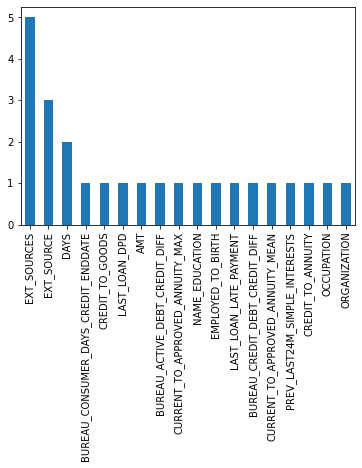

In [31]:
feature_importances.head(n=25)['feature_class'].value_counts().plot(kind='bar')